# Modelo preditivo para prever a equipe vencedora em partidas de League of Legends
League of Legends é um dos jogos competitivos mais populares do mundo, caracterizado por alta complexidade estratégica, tomada de decisão em tempo real e múltiplos fatores que influenciam o resultado de uma partida. A partir disso, surge a seguinte questão: é possível prever qual equipe vencerá uma partida com base apenas em suas estatísticas dos primeiros dez minutos de jogo?

Este projeto tem como objetivo desenvolver um modelo preditivo capaz de identificar a equipe vencedora (blue team ou red team) utilizando exclusivamente dados estatísticos agregados do começo das partidas. Para isso, são aplicadas técnicas de análise exploratória de dados, engenharia de features e Machine Learning, além de estratégias de otimização de hiperparâmetros e validação cruzada.

A proposta busca avaliar até que ponto informações quantitativas como ouro, experiência, objetivos conquistados e desempenho em combate são suficientes para explicar o desfecho de uma partida, considerando a natureza dinâmica e parcialmente imprevisível do jogo.

## Importando as bibliotecas, carregando e tratando os dados

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report

from xgboost import XGBClassifier

In [53]:
df = pd.read_csv('Base_M43_Pratique_LOL_RANKED_WIN.csv')

In [46]:
df.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

In [48]:
# removendo gameId por não ter valor real para as previsões do modelo
df.drop('gameId', axis=1, inplace=True)

O dataset não apresenta nulos e os tipos dos dados estão corretos, removi a coluna gameId porque ela não vai ter valor real nas próximas análises e na modelagem.

### Buscando por outliers e explicando do porquê mantê-los é mais apropriado neste caso

In [49]:
df.describe()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
count,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,...,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,0.499038,22.288288,2.824881,0.504808,6.183925,6.137666,6.645106,0.549954,0.361980,0.187974,...,0.043021,16489.041401,6.925316,17961.730438,217.349226,51.313088,-14.414111,33.620306,21.734923,1648.904140
std,0.500024,18.019177,2.174998,0.500002,3.011028,2.933818,4.064520,0.625527,0.480597,0.390712,...,0.216900,1490.888406,0.305311,1198.583912,21.911668,10.027885,2453.349179,1920.370438,2.191167,149.088841
min,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,11212.000000,4.800000,10465.000000,107.000000,4.000000,-11467.000000,-8348.000000,10.700000,1121.200000
25%,0.000000,14.000000,1.000000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,0.000000,...,0.000000,15427.500000,6.800000,17209.500000,203.000000,44.000000,-1596.000000,-1212.000000,20.300000,1542.750000
50%,0.000000,16.000000,3.000000,1.000000,6.000000,6.000000,6.000000,0.000000,0.000000,0.000000,...,0.000000,16378.000000,7.000000,17974.000000,218.000000,51.000000,-14.000000,28.000000,21.800000,1637.800000
75%,1.000000,20.000000,4.000000,1.000000,8.000000,8.000000,9.000000,1.000000,1.000000,0.000000,...,0.000000,17418.500000,7.200000,18764.500000,233.000000,57.000000,1585.500000,1290.500000,23.300000,1741.850000
max,1.000000,250.000000,27.000000,1.000000,22.000000,22.000000,29.000000,2.000000,1.000000,1.000000,...,2.000000,22732.000000,8.200000,22269.000000,289.000000,92.000000,10830.000000,9333.000000,28.900000,2273.200000


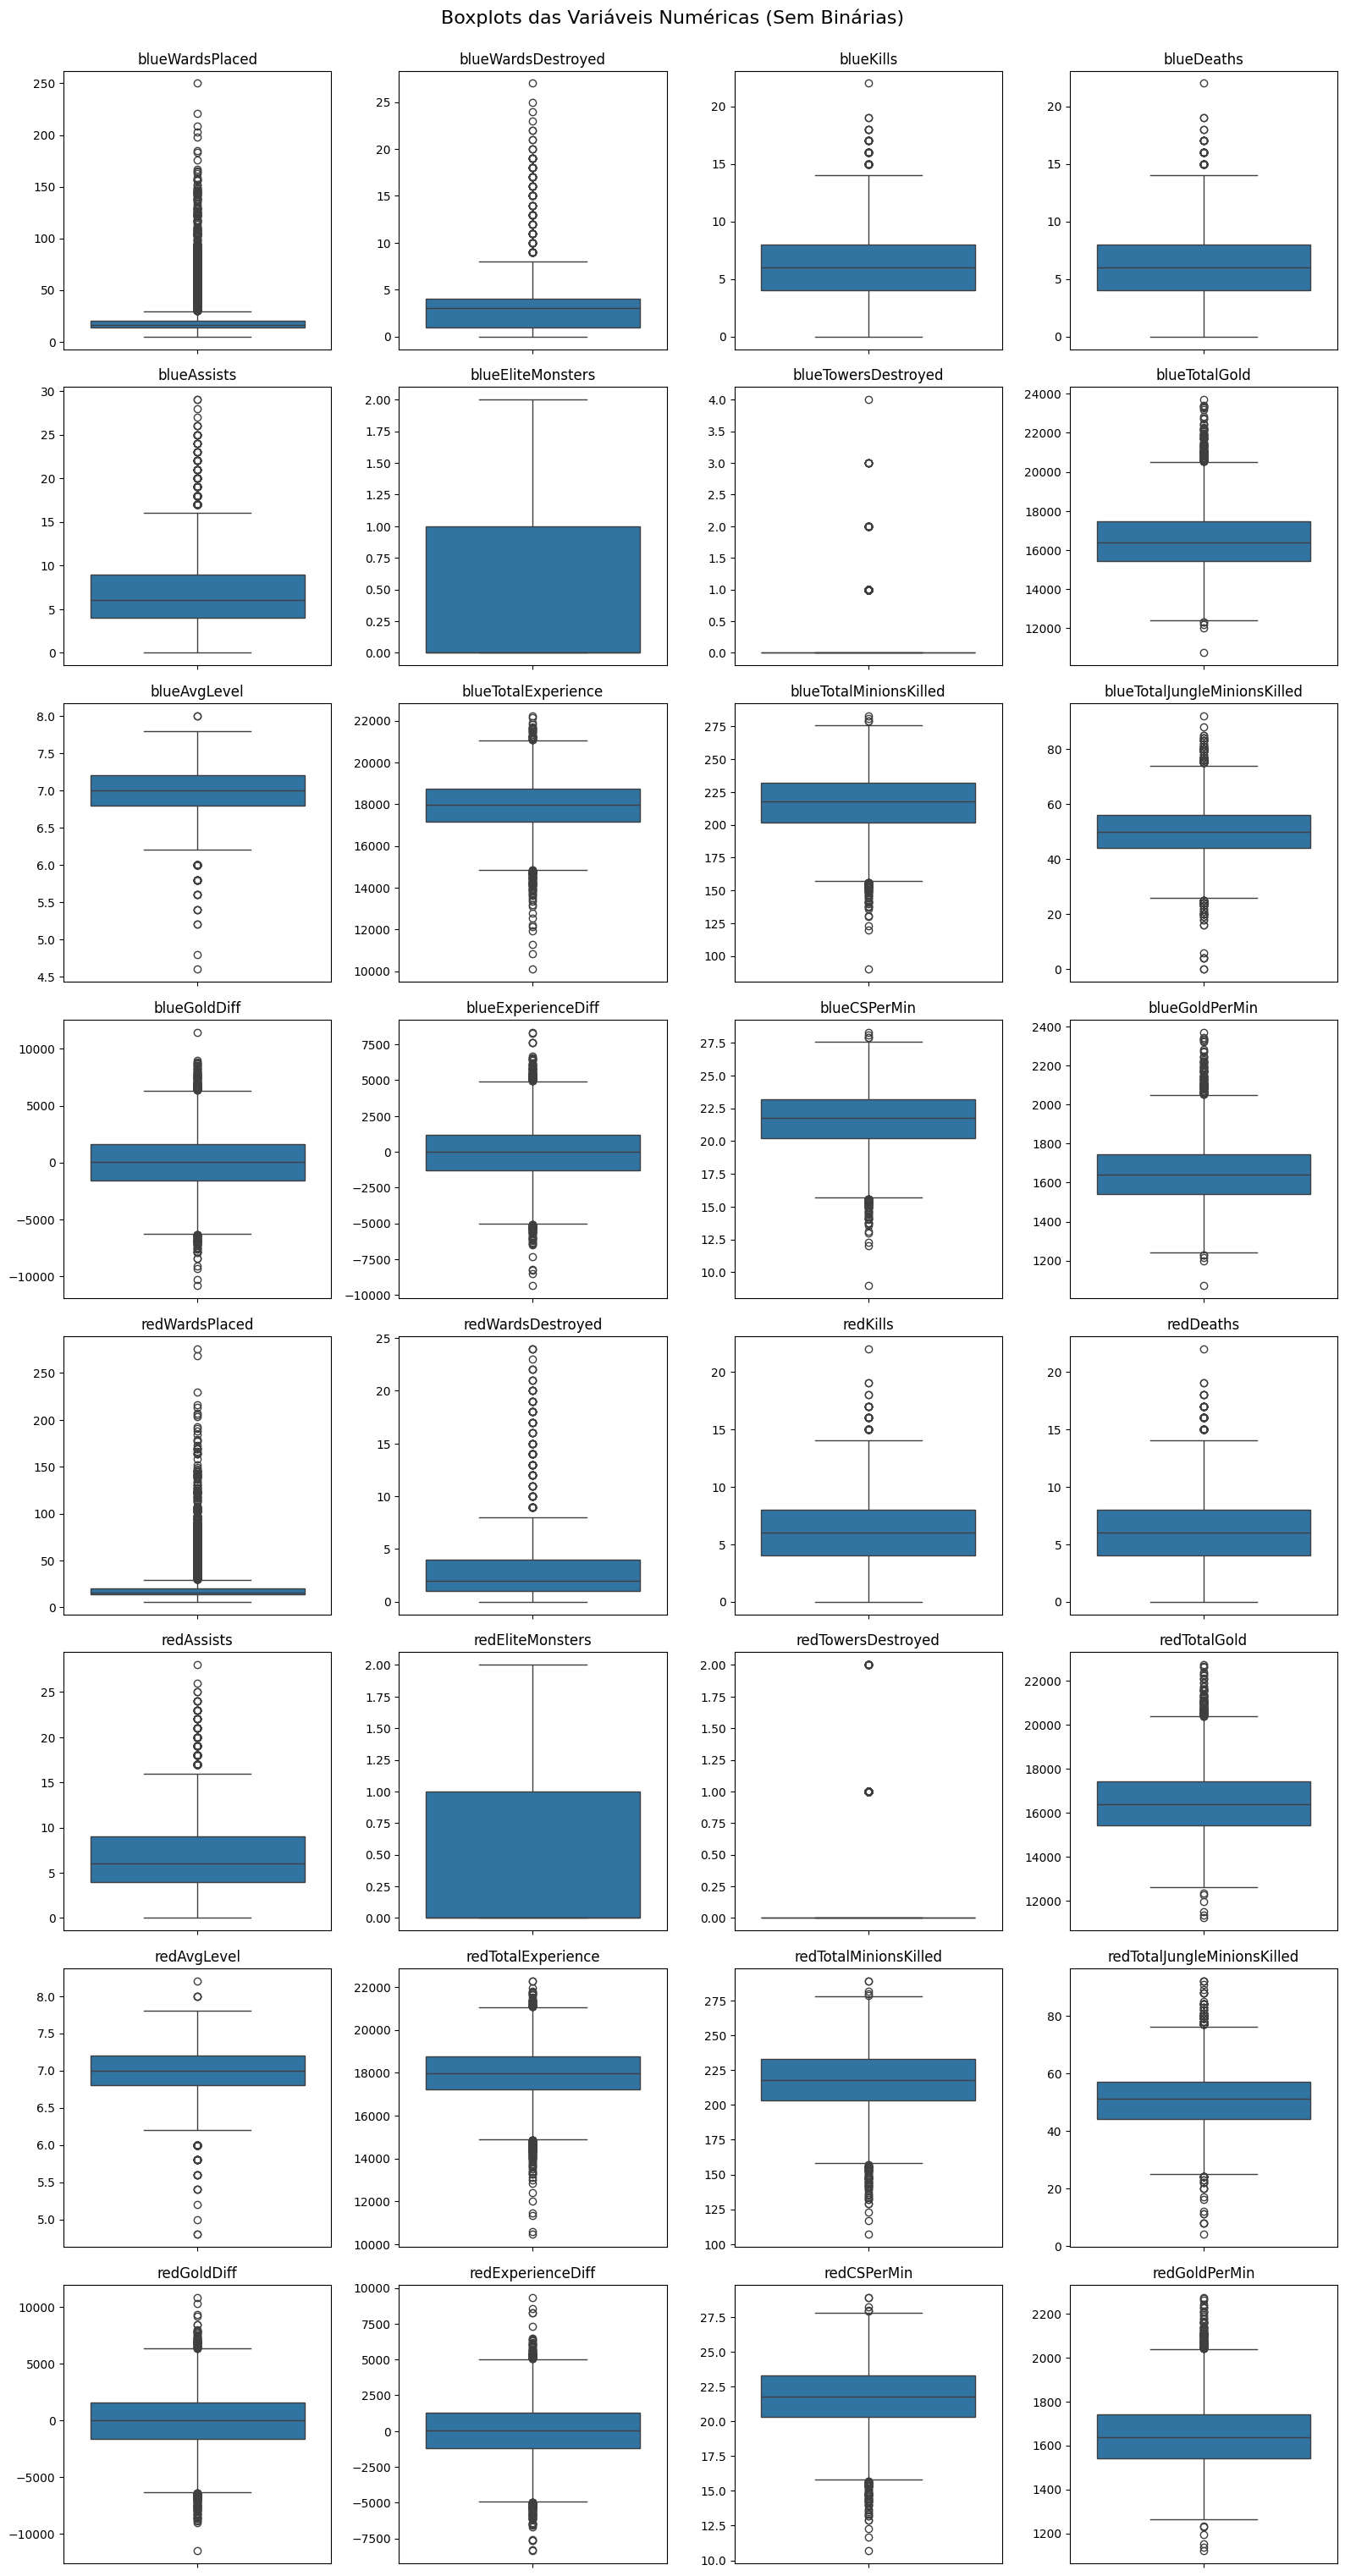

In [50]:
# Seleciona colunas numéricas
numerical_cols = df.select_dtypes(include=np.number).columns

# Remove colunas binárias (apenas 0 e 1) e a variável target
non_binary_cols = [
    col for col in numerical_cols
    if col != 'blueWins' and df[col].nunique() > 2
]

# Verifica se há colunas para plotar
if not non_binary_cols:
    print("Não há colunas numéricas não binárias para plotar.")
else:
    cols_per_row = 4
    n_cols = len(non_binary_cols)
    n_rows = (n_cols + cols_per_row - 1) // cols_per_row

    # Cria os subplots
    fig, axes = plt.subplots(n_rows, cols_per_row,
                             figsize=(4 * cols_per_row, 4 * n_rows))
    fig.suptitle('Boxplots das Variáveis Numéricas (Sem Binárias)', fontsize=16)

    axes = axes.flatten()  # Facilita a iteração

    for i, col in enumerate(non_binary_cols):
        # Boxplot mostrando toda a faixa (min a max)
        sns.boxplot(y=df[col], ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_ylabel('')

    # Remove eixos vazios
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

In [57]:
# tratando a coluna de wards colocadas
df_clean = df.copy()
df_clean['blueWardsPlaced'] = np.where(df_clean['blueWardsPlaced'] > 40, df_clean['blueWardsPlaced'].median(), df_clean['blueWardsPlaced'])
df_clean['redWardsPlaced'] = np.where(df_clean['redWardsPlaced'] > 40, df_clean['redWardsPlaced'].median(), df_clean['blueWardsPlaced'])

#### Tratamento de Dados e Análise de Outliers
A análise revelou que a base de dados compreende apenas os 10 minutos iniciais de jogo (early game). Com esse recorte fixo, a estratégia de tratamento de valores extremos foi ajustada para distinguir variações reais de jogo de erros de registo.

1. "Stomp" e Snowball (Dados Mantidos)
Valores elevados em métricas como blueGoldDiff, blueKills e blueTotalExperience foram preservados. No League of Legends, estes "outliers" representam o fenómeno de snowball, onde uma equipa domina o adversário rapidamente. Remover estes dados eliminaria cenários reais de vitória esmagadora, enviesando a capacidade de previsão do modelo.

2. Inconsistências Mecânicas (Dados Removidos)
A coluna blueWardsPlaced apresentou valores acima de 100, identificados como erros de recolha. Mecanicamente, é impossível para uma equipa colocar tal quantidade de sentinelas em 10 minutos devido aos tempos de recarga (cooldown) dos itens. Foram também filtrados registos que violam limites lógicos do jogo, como a presença de mais de 2 monstros de elite ou 1 dragão no período.

3. Conclusão
A limpeza foi seletiva: eliminou-se o ruído técnico (wards impossíveis), mas manteve-se a variabilidade competitiva (vantagem económica). Esta abordagem garante que o modelo de Machine Learning aprenda com cenários de alta performance sem ser corrompido por dados mecanicamente inválidos.

### Tratando variáveis redudantes e multicolinearidade

Algumas variáveis do dataset podem representar essencialmente a mesma informação sob perspectivas opostas, gerando correlações artificialmente elevadas e potencial multicolinearidade. Um exemplo claro é o par Blue First Blood e Red First Blood: como apenas uma equipe pode conquistar o primeiro abate, quando o time azul assume valor 1, o time vermelho necessariamente assume valor 0, e vice-versa.

Dessa forma, torna-se necessária a realização de uma análise de correlação para identificar essas dependências estruturais entre colunas e, quando apropriado, remover variáveis redundantes. Essa etapa contribui para reduzir multicolinearidade, evitar redundância informacional e tornar o modelo mais estável e interpretável.

<Axes: >

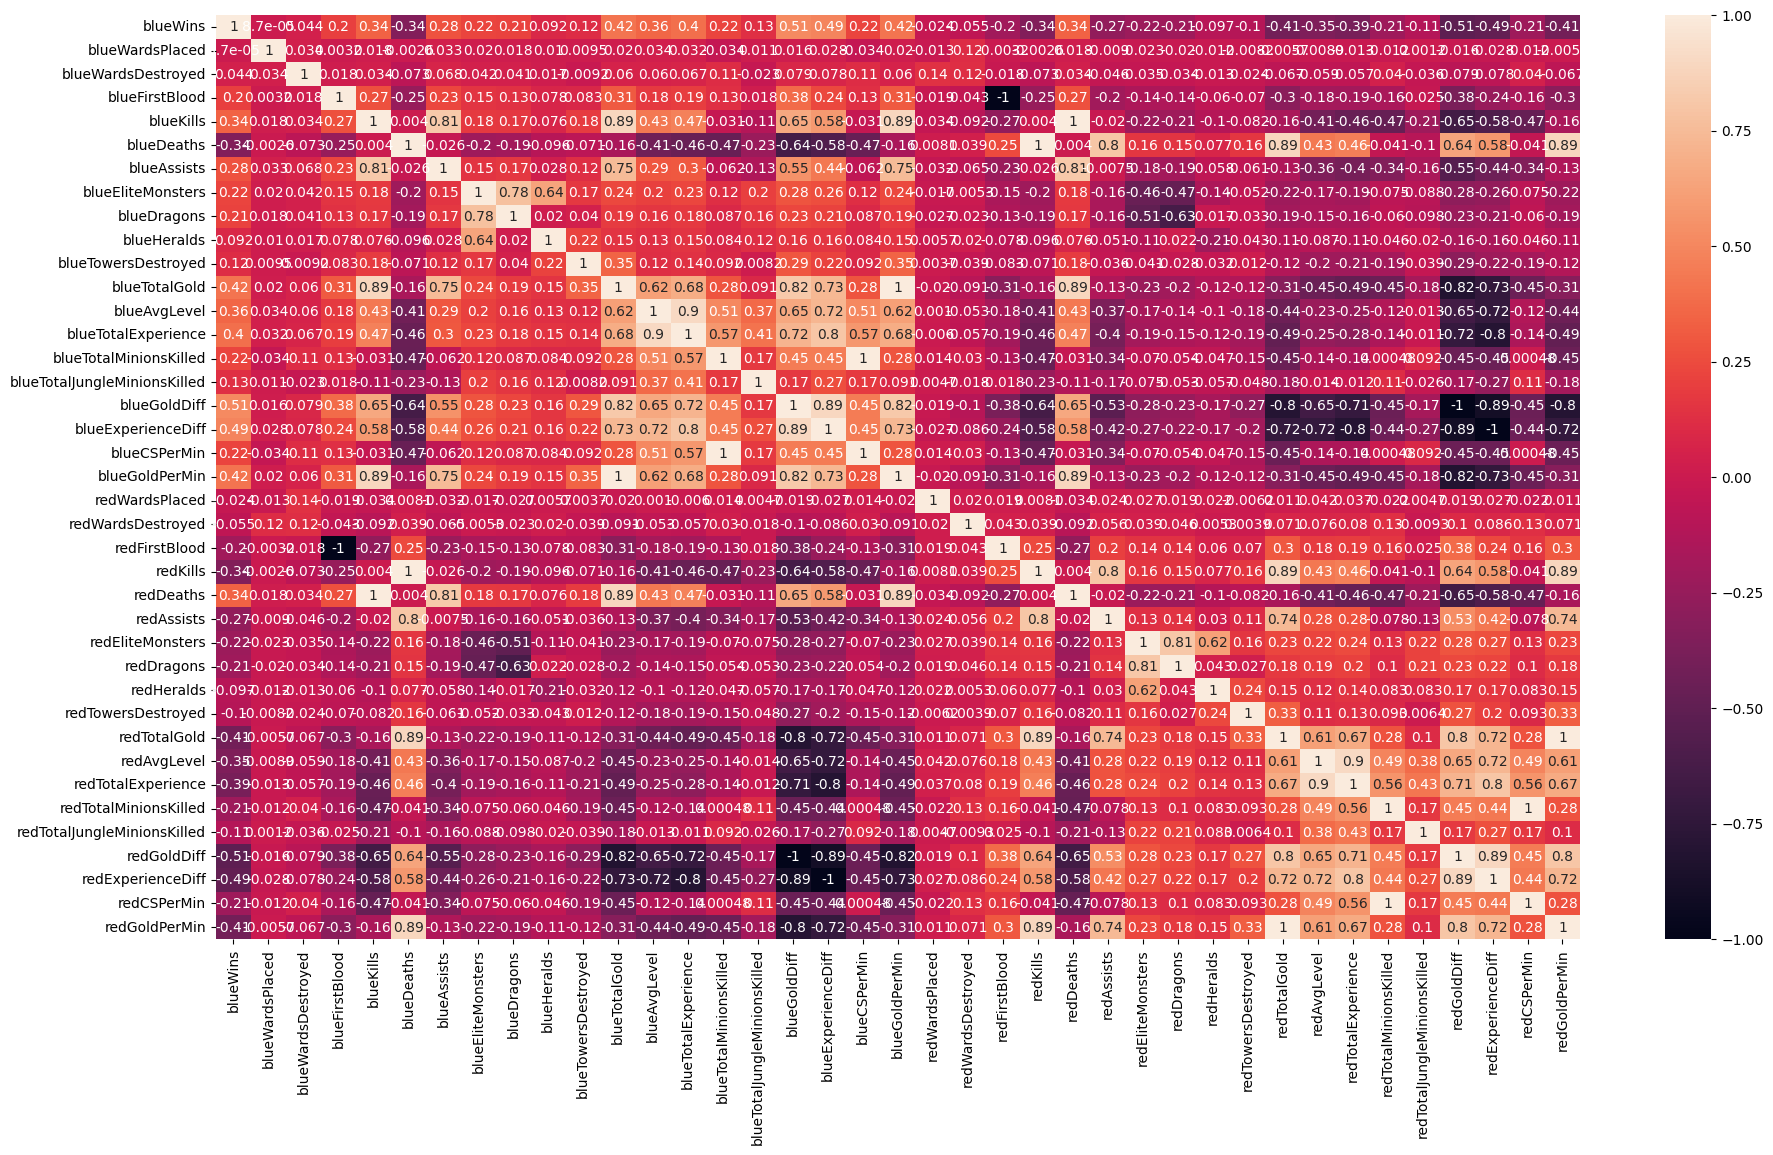

In [9]:
# observando a correlação das variáveis
plt.figure(figsize=(22,12))
sns.heatmap(data=df.corr(),annot=True)

Algumas colunas apresentam correlação muito alta não porque tragam informações diferentes, mas porque são essencialmente a mesma estatística vista de outro ângulo. Entre os principais casos identificados estão:

- redKills × blueDeaths

- redFirstBlood × blueFirstBlood

- redGoldDiff × blueGoldDiff

- redExperienceDiff × blueExperienceDiff

- blueTotalGold × blueGoldPerMin

- blueTotalMinionsKilled × blueCSPerMin

- redTotalGold × redGoldPerMin

- redTotalMinionsKilled × redCSPerMin

Em muitos desses exemplos, uma variável é consequência direta da outra ou representa exatamente a mesma informação sob a perspectiva do time adversário. Isso gera uma correlação alta de forma estrutural, criando redundância no conjunto de dados.

Para evitar multicolinearidade e manter apenas informações realmente relevantes, as colunas redundantes serão removidas, preservando uma relação mais coerente e informativa entre as variáveis do modelo.

In [10]:
# removendo as colunas que contribuem para redundância dos dados
colunas_a_remover = ['redKills','redDeaths','redFirstBlood','redGoldDiff','redExperienceDiff','redTotalGold','redTotalMinionsKilled','blueTotalGold','blueTotalMinionsKilled']

df_clean = df_clean.drop(colunas_a_remover, axis=1)

# Análise exploratória

Considero pertinente implementar um procedimento para identificar as variáveis mais relevantes do modelo, com o objetivo de tornar o dataset mais enxuto e informativo. A seleção de features pode contribuir para uma Análise Exploratória de Dados (EDA) mais direcionada.

In [11]:
# descorindo as importâncias de cada varíavel para otimizar a EDA
X = df_clean.drop('blueWins', axis=1)
y = df_clean['blueWins']

mi = mutual_info_classif(X, y, random_state=42)

mi_scores = pd.DataFrame({'Feature': X.columns, 'MI': mi}).sort_values('MI', ascending=False)

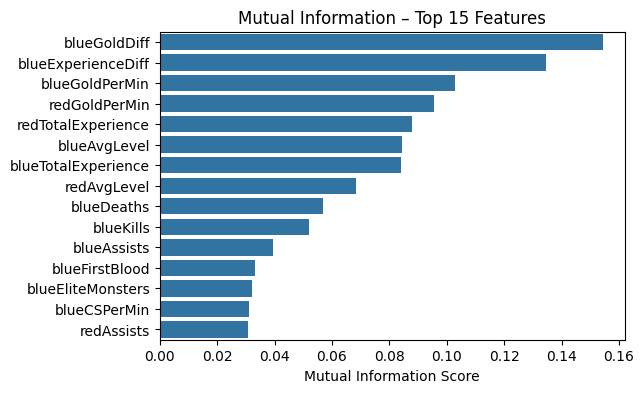

In [12]:
# plotando as features mais importantes
plt.figure(figsize=(6, 4))
sns.barplot(x='MI', y='Feature', data=mi_scores.head(15))
plt.title('Mutual Information – Top 15 Features')
plt.xlabel('Mutual Information Score')
plt.ylabel('')
plt.show()

A análise das feature importances revelou um padrão relevante: acumular vantagem econômica e manter um bom ritmo de crescimento ao longo do começo da partida parecem ser fatores determinantes para a vitória.

Com base nessa observação, surgem três hipóteses principais:

- A vantagem de ouro e experiência (XP) diferencia de forma clara vitórias e derrotas.

- O ritmo de crescimento (métricas por minuto) exerce maior influência no resultado do que eventos isolados, como abates específicos.

- A conquista de objetivos impacta o desfecho da partida, mas pode ser consequência de uma vantagem previamente construída.

O próximo passo consiste em desenvolver visualizações que permitam analisar a relação entre essas variáveis e a variável alvo, a fim de validar ou refutar as hipóteses propostas com base em evidências empíricas.

Hipótese: "A vantagem de ouro e experiência (XP) diferencia de forma clara vitórias e derrotas."

<Axes: xlabel='blueGoldDiff', ylabel='Density'>

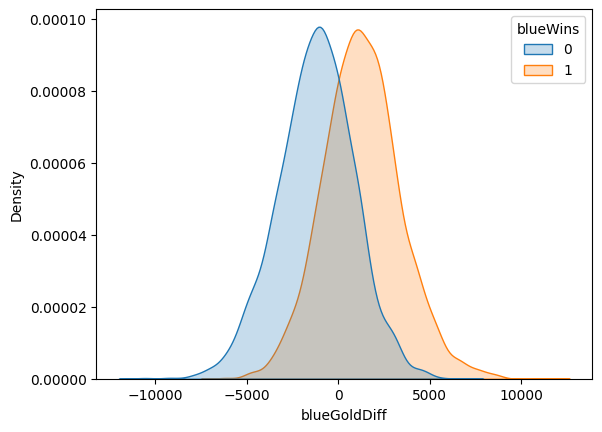

In [13]:
# relação de diferença de ouro com as vitórias
sns.kdeplot(data=df_clean, x='blueGoldDiff', hue='blueWins', fill=True)

<Axes: xlabel='blueExperienceDiff', ylabel='Density'>

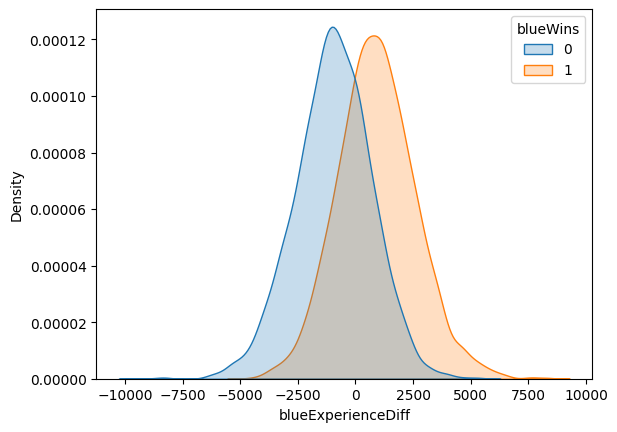

In [14]:
# relação de diferença de experiência com as vitórias
sns.kdeplot(data=df_clean, x='blueExperienceDiff', hue='blueWins', fill=True)

<Axes: xlabel='blueExperienceDiff', ylabel='blueGoldDiff'>

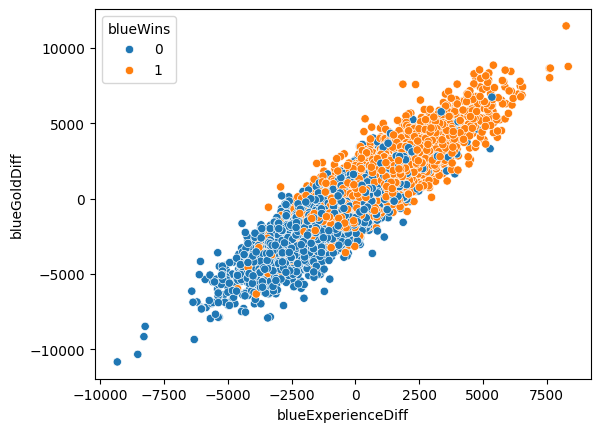

In [15]:
# disperção relacionando a diferença de ouro e experiência juntas com as vitórias
sns.scatterplot(data=df_clean,x='blueExperienceDiff',y='blueGoldDiff',hue='blueWins')

Conclusão: A vantagem de ouro e experiência é claramente um dos principais fatores associados à vitória, mas não cria uma separação perfeitamente linear entre as classes.

Hipótese: "O ritmo de crescimento (métricas por minuto) exerce maior influência no resultado do que eventos isolados, como abates específicos."

<Axes: xlabel='blueWins', ylabel='blueGoldPerMin'>

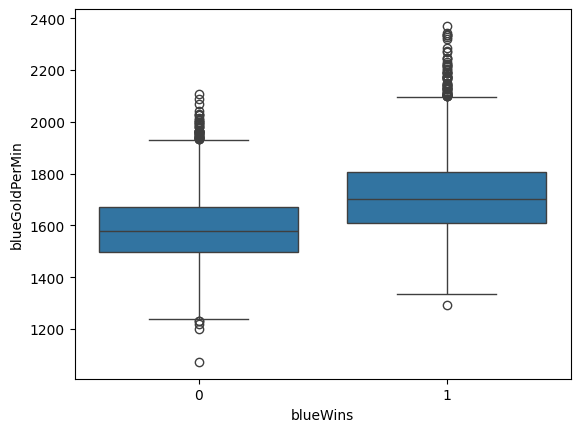

In [16]:
# relacionando o farm de ouro por minuto com as vitórias
sns.boxplot(x='blueWins', y='blueGoldPerMin', data=df)

<Axes: xlabel='blueWins', ylabel='blueCSPerMin'>

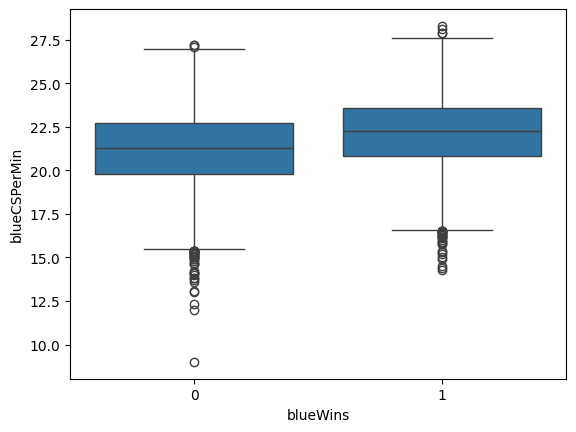

In [17]:
# relacionando o farm de experiência por minuto com as vitórias
sns.boxplot(x='blueWins', y='blueCSPerMin', data=df)

<Axes: xlabel='blueGoldPerMin', ylabel='blueCSPerMin'>

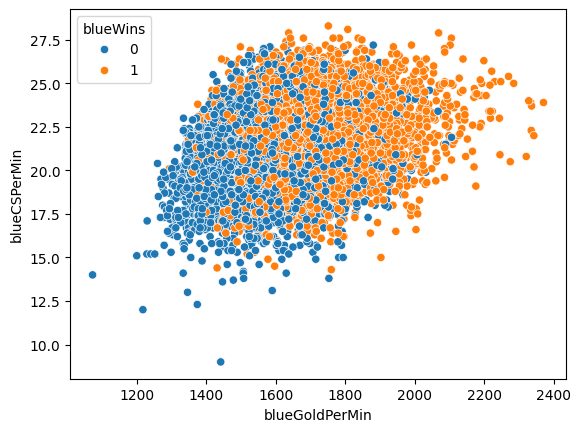

In [18]:
# disperção relacionando o farm de ouro e experiência por minuto juntos com as vitórias
sns.scatterplot(x='blueGoldPerMin', y='blueCSPerMin', data=df,hue='blueWins')

Conclusão: As métricas de crescimento por minuto apresentam um padrão de separação mais estável e estrutural do que eventos isolados como abates. Isso sugere que o ritmo de crescimento é um indicador mais robusto de vitória do que eventos pontuais.

Hipótese: "A conquista de objetivos impacta o desfecho da partida, mas pode ser consequência de uma vantagem previamente construída."

In [19]:
# observando a distribuição da variável target baseado no número de monstros épicos eliminados
pd.crosstab(df['blueEliteMonsters'], df['blueWins'], normalize='index')

blueWins,0,1
blueEliteMonsters,,
0,0.601435,0.398565
1,0.413656,0.586344
2,0.264789,0.735211


A tabela de proporção mostra um padrão claro:

- Quando o time azul não conquista nenhum monstro épico, a probabilidade de vitória é menor (~39%).

- Com 1 objetivo conquistado, a probabilidade de vitória sobe (~58%).

- Com 2 objetivos, a taxa de vitória aumenta ainda mais (~73%).

Isso indica que a conquista de objetivos está fortemente associada à vitória.

No entanto, é importante interpretar com cautela: objetivos como dragões e arautos normalmente são conquistados por equipes que já possuem controle de mapa, vantagem econômica ou superioridade em lutas. Ou seja, os objetivos podem não ser necessariamente a causa primária da vitória, mas sim um reflexo de uma vantagem já estabelecida.

####**Conclusão final da análise exploratória:**
A análise das três hipóteses revela um padrão coerente:

- Vantagens de ouro e experiência diferenciam vitórias e derrotas, mas não garantem a vitória sozinhos.

- O ritmo de crescimento (métricas por minuto) apresenta um poder explicativo mais consistente, indicando que eficiência contínua é mais determinante do que eventos isolados.

- A conquista de objetivos está fortemente associada à vitória, mas provavelmente decorre de uma vantagem previamente construída.

Em conjunto, os resultados indicam que o desfecho das partidas está principalmente relacionado à construção progressiva de vantagem econômica e estrutural ao longo do jogo, enquanto eventos pontuais e objetivos funcionam como reforço dessa superioridade e não como fatores isolados determinantes.

## Engenharia de features

In [58]:
# razão entre vantagem de ouro e vantagem de experiência
df_clean['gold_xp_ratio'] = df_clean['blueGoldDiff'] / (df_clean['blueExperienceDiff'] + 1)

# score bruto de combate do time azul
df_clean['blueCombatScore'] = (
    df_clean['blueKills'] +
    df_clean['blueAssists'] -
    df_clean['blueDeaths']
)

# diferença líquida de abates do time azul
df_clean['kill_diff'] = df_clean['blueKills'] - df_clean['blueDeaths']

# razão de farm por minuto entre azul e vermelho
df_clean['cs_ratio'] = df_clean['blueCSPerMin'] / (df_clean['redCSPerMin'] + 1)
# tratamento de valores infinitos gerados por divisões
df_clean = df_clean.replace([np.inf, -np.inf], np.nan)
# substitui NaN por 0 para evitar problemas no treinamento do modelo
df_clean = df_clean.fillna(0)

# diferença de objetivos épicos conquistados
df_clean['objective_diff'] = (
    df_clean['blueEliteMonsters'] -
    df_clean['redEliteMonsters']
)

#Pré-Processamento e 1° Treinamento do Modelo

In [59]:
# observando a distribuição da variável target para decidir se existe a necessidade de stratify ou SMOTE'
df['blueWins'].value_counts(normalize=True)

,proportion
blueWins,
0,0.500962
1,0.499038


In [60]:
# separando treino e teste
X = df_clean.drop(columns=['blueWins'])
y = df_clean['blueWins']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
# distribuição de hiperparâmetros
param_distributions = {
    'n_estimators': [200, 300, 500, 800],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

# instanciando o xgb
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# instanciando o randomizedsearch
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# treinamento
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           num_parallel_tree=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.3],
                                        'learning_rate': [0.01, 0.03, 0.05,
                                                          0.1],
                                        'max_depth': [3, 4, 5, 6, 8],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [200, 300, 500, 800],
                                        'reg_alpha': [0, 0.1, 0.5],
                                        'reg_lambda': [1, 1.5, 2],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [62]:
# melhor modelo com os melhores hiperparâmetros
best_model = random_search.best_estimator_
print(random_search.best_params_)
print('\n', random_search.best_score_)

{'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 800, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.6}

 0.8045981483466076


In [63]:
# avaliando o modelo
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_pred_proba))

              precision    recall  f1-score   support

           0       0.72      0.73      0.72       983
           1       0.73      0.72      0.72       993

    accuracy                           0.72      1976
   macro avg       0.72      0.72      0.72      1976
weighted avg       0.72      0.72      0.72      1976

ROC-AUC: 0.8127267269666916


In [64]:
# observando as features mais importantes
importance = best_model.get_booster().get_score(importance_type='gain')

importance_df = (
    pd.DataFrame(importance.items(), columns=['Feature', 'Gain'])
    .sort_values('Gain', ascending=False).reset_index(drop=True)
)

top_features = importance_df.head(20)['Feature']

In [65]:
top_features

,Feature
0,redGoldDiff
1,blueGoldDiff
2,redExperienceDiff
3,blueExperienceDiff
4,kill_diff
5,objective_diff
6,redTotalGold
7,blueEliteMonsters
8,blueDragons
9,redEliteMonsters


Após a aplicação de técnicas de feature engineering e a remoção de variáveis redundantes com alta multicolinearidade, o modelo apresentou accuracy/f1-score de 0.72 e ROC-AUC de 0.81. Esses resultados indicam um desempenho consistente e aceitável, mostrando que o modelo consegue diferenciar razoavelmente bem vitórias e derrotas.

Mesmo com os ajustes realizados, as métricas não atingiram um nível considerado ótimo. Isso pode estar relacionado ao possível teto de explicabilidade da base, já que o dataset contém apenas estatísticas agregadas da partida e não inclui informações importantes como draft de campeões, sinergias, counters e composição das equipes.

Além disso, League of Legends é um jogo altamente dinâmico e influenciado por fatores humanos. Situações como jogadores que abandonam a partida, presença de smurfs, comportamento inadequado (trolls), diferenças de habilidade individual e tomada de decisão sob pressão impactam diretamente o resultado e não estão representadas nos dados. Esses elementos introduzem um nível de imprevisibilidade que o modelo não consegue capturar apenas com estatísticas.

Ainda assim, o modelo será retreinado utilizando apenas as features mais relevantes, com o objetivo de verificar se a redução de ruído e um conjunto de dados mais enxuto podem gerar alguma melhoria adicional no desempenho.

## 2° Treinamento com as melhores features


In [66]:
# criando uma lista com as features mais importantes e a variável target para o retreino
features_list = top_features.unique().tolist()
features_list.append('blueWins')

df_features = df_clean[features_list]

In [67]:
# treino e teste
X = df_features.drop(columns=['blueWins'])
y = df_features['blueWins']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
# distribuição de hiperparâmetros
param_distributions = {
    'n_estimators': [200, 300, 500, 800],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

# instanciando o xgb
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# instanciando o randomizedsearch
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# treinamento
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           num_parallel_tree=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.3],
                                        'learning_rate': [0.01, 0.03, 0.05,
                                                          0.1],
                                        'max_depth': [3, 4, 5, 6, 8],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [200, 300, 500, 800],
                                        'reg_alpha': [0, 0.1, 0.5],
                                        'reg_lambda': [1, 1.5, 2],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [69]:
# melhor modelo com os melhores hiperparâmetros
best_model = random_search.best_estimator_

print(random_search.best_params_)
print('\n', random_search.best_score_)

{'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.5, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.8}

 0.8060083778436447


In [70]:
# avaliando o modelo retreinado para entender se cheguei no teto de informações da base
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_pred_proba))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73       983
           1       0.73      0.73      0.73       993

    accuracy                           0.73      1976
   macro avg       0.73      0.73      0.73      1976
weighted avg       0.73      0.73      0.73      1976

ROC-AUC: 0.812847613866752


**Resultado do Modelo Retreinado**

Após o retreinamento do modelo utilizando apenas as features consideradas mais relevantes, os resultados permaneceram praticamente estáveis:

- Accuracy: 0.73

- F1-score: 0.73

- ROC-AUC: 0.81

Houve uma leve melhora na acurácia (de 0.72 para 0.73), enquanto o ROC-AUC se manteve no mesmo patamar. Isso indica que a remoção de variáveis redundantes e a redução de ruído tornaram o modelo um pouco mais consistente, mas não alteraram de forma significativa sua capacidade preditiva.

Esse comportamento reforça os pontos já discutidos anteriormente: o modelo atinge um desempenho sólido, porém limitado pelo próprio conjunto de dados. Como a base contém apenas estatísticas agregadas das partidas, fatores decisivos como draft de campeões, sinergias, counters, decisões estratégicas em tempo real e, principalmente, variáveis humanas (jogadores abandonando partidas, smurfs, trolls e diferenças individuais de habilidade) não estão representados.

Esses elementos introduzem uma variabilidade natural no resultado das partidas, criando um nível de imprevisibilidade que não pode ser totalmente capturado por métricas numéricas agregadas.

# Conclusão Final do Projeto

Ao longo do projeto, foram realizadas:

- Identificação e remoção de multicolinearidade

- Análise exploratória dos dados

- Criação de novas variáveis via feature engineering

- Otimização de hiperparâmetros com validação cruzada

- Interpretação do modelo por meio de análise de importância das variáveis

- Testes com redução de features para minimizar ruído

O modelo final apresentou desempenho consistente (ROC-AUC ≈ 0.81), demonstrando boa capacidade de ranqueamento entre vitórias e derrotas. As análises indicaram que vantagem econômica, experiência acumulada e ritmo de crescimento são os principais fatores associados à vitória, enquanto eventos isolados têm menor impacto estrutural.

Os resultados sugerem que o modelo atingiu um provável teto informacional da base, evidenciando que parte do desfecho das partidas está ligada a fatores externos não observáveis no dataset. Ainda assim, o projeto demonstra aplicação sólida de técnicas de Machine Learning, validação estatística e interpretação de modelos em um problema real e complexo.

De forma geral, o objetivo proposto foi alcançado: construir um modelo preditivo eficiente, interpretar seus resultados e compreender tanto seu potencial quanto suas limitações.